# Assignment 2: Multi-layer feed forward neural network
Submitted by 18MCMT28

Name: K. Sai Somanath

## Question 3

In [1]:
# Necessary imports
import os
import struct
import numpy as np
from matplotlib import pyplot as plt 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [2]:
# Some utility functions to read and extract data in desired format
def read(dataset = "training", path = "."):
    if dataset is "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    else:
        print("dataset must be 'testing' or 'training'")

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        _, __, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows * cols)

    get_img = lambda index: (lbl[index], img[index])

    # Create an iterator which returns each image in turn
    for i in range(len(lbl)):
        yield get_img(i)

def show(image):
    from matplotlib import pyplot
    import matplotlib as mpl
    fig = pyplot.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image.reshape(28, 28), cmap=mpl.cm.gray)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    pyplot.show()

In [3]:
# Reading the images
TRAIN = read('training', 'MNIST'); TEST = read('testing', 'MNIST')

In [4]:
img_train = []; lbl_train = []
img_test = []; lbl_test = []

for temp in TRAIN:
    img_train.append(temp[1])
    lbl_train.append(temp[0])

for temp in TEST:
    img_test.append(temp[1])
    lbl_test.append(temp[0])

img_train = np.array(img_train); lbl_train = np.array(lbl_train)
img_test = np.array(img_test); lbl_test = np.array(lbl_test)

### Deskew functions


In [5]:
from scipy.ndimage import interpolation

def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix

def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    img = interpolation.affine_transform(image,affine,offset=offset)
    return (img - img.min()) / (img.max() - img.min())



Let's look at an unskewed image

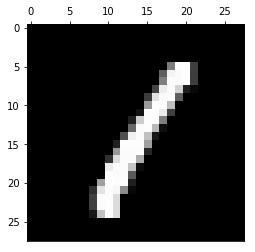

In [6]:
show(img_train[3])

Now, let us look at the deskewed version of the image

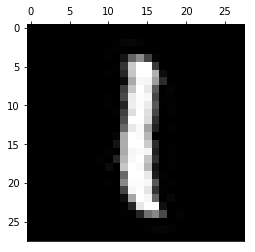

In [7]:
show(deskew(img_train[3].reshape(28, 28)))

We now see what deskew does. It in a way centers all the information(pixels) to the center. This should help the network learn better...

## The MLFFNN

In [8]:
class Relu:
    @staticmethod
    def activation(z):
        z[z < 0] = 0
        return z
    
    @staticmethod
    def derivative(z):
        z[z < 0] = 0
        z[z > 0] = 1
        return z
        
class Sigmoid:
    @staticmethod
    def activation(z):
        return 1 / (1 + np.exp(-z))
    
    @staticmethod
    def derivative(z):
        return Sigmoid.activation(z) * (1 - Sigmoid.activation(z))
    
class Softmax:
    @staticmethod
    def activation(z):
        exps = np.exp(z)
        return exps / np.sum(exps)
    
    @staticmethod
    def derivative(z):
        s = Softmax.activation(z).reshape(-1,1)
        return np.diagflat(s) - np.dot(s, s.T)

class MSE:
    def __init__(self, activation_fn=None):
        self.activation_fn = activation_fn
            
    def activation(self, z):
        return self.activation_fn.activation(z)

    @staticmethod
    def loss(y_true, y_pred):
        return np.mean((y_pred - y_true)**2)

    @staticmethod
    def derivative(y_true, y_pred):
        return y_pred - y_true

    def delta(self, y_true, y_pred):
        return self.derivative(y_true, y_pred) * self.activation_fn.derivative(y_pred)


class Cross:
    def __init__(self, activation_fn=None):
        self.activation_fn = activation_fn
            
    def activation(self, z):
        return self.activation_fn.activation(z)
    @staticmethod
    def derivative(y1, y2):
        return y2 - y1
    @staticmethod
    def loss(y_true, X):
        m = y_true.shape[1]
        return (np.sum(np.multiply(y_true, np.log(X))) * (-1. / m) )
    
    def delta(self, y_true, y_pred):
        return self.derivative(y_true, y_pred) * self.activation_fn.derivative(y_pred)
        
class NeuralNetwork(object):
    def __init__(self, dimensions, activation_fns):
        self.dimensions = dimensions
        self.n_layers = len(dimensions)
        self.loss = None
        self.learning_rate = None
        self.weights = {}
        self.bais = {}
        self.activations = {}
        for i in range(self.n_layers - 1):
            self.weights[i + 1] = np.random.randn(dimensions[i], dimensions[i + 1]) / np.sqrt(dimensions[i])
            self.bais[i + 1] = np.zeros(dimensions[i + 1])
            self.activations[i + 2] = activation_fns[i]
    
    def __deepcopy__(self, memo):
        deepcopy_method = self.__deepcopy__
        self.__deepcopy__ = None
        cp = deepcopy(self, memo)
        self.__deepcopy__ = deepcopy_method
        # custom treatments
        cp.weights = {}; cp.bais = {}
        for i in range(cp.n_layers - 1):
            cp.weights[i + 1] = np.random.randn(cp.dimensions[i], cp.dimensions[i + 1]) / np.sqrt(cp.dimensions[i])
            cp.bais[i + 1] = np.zeros(cp.dimensions[i + 1])

        return cp
    
    def feed_forward(self, x):
        z = {}
        activated = {1: x}
        for i in range(1, self.n_layers):
            z[i + 1] = np.dot(activated[i], self.weights[i]) + self.bais[i]
            activated[i + 1] = self.activations[i + 1].activation(z[i + 1])
        return z, activated
    
    def back_propagation(self, z, a, y_true):
        delta = self.loss.delta(y_true, a[self.n_layers])
        partial_derivative = np.dot(a[self.n_layers - 1].T, delta)

        update_params = {
            self.n_layers - 1: (partial_derivative, delta)
        }

        for i in reversed(range(2, self.n_layers)):
            delta = np.dot(delta, self.weights[i].T) * self.activations[i].derivative(z[i])
            partial_derivative = np.dot(a[i - 1].T, delta)
            update_params[i - 1] = (partial_derivative, delta)

        for key, values in update_params.items():
            self.update_fn(key, values[0], values[1])
        
    def update_fn(self, key, partial_derivative, delta):
        self.weights[key] -= self.learning_rate * partial_derivative
        self.bais[key] -= self.learning_rate * np.mean(delta, 0)

    def learn(self, x, y_true, loss, epochs, batch_size, learning_rate):
        self.loss = loss(self.activations[self.n_layers])
        self.learning_rate = learning_rate
        for i in range(epochs):
            seed = np.arange(x.shape[0])
            np.random.shuffle(seed)
            x_ = x[seed]
            y_ = y_true[seed]
            for j in range(x.shape[0] // batch_size):
                k = j * batch_size
                l = (j + 1) * batch_size
                z, a = self.feed_forward(x_[k:l])
                self.back_propagation(z, a, y_[k:l])
            _, _a = self.feed_forward(x)
            print("Epoch:", i + 1, "Loss:", self.loss.loss(y_true, _a[self.n_layers]), end='\r')
    
    def predict(self, x):
        _, a = self.feed_forward(x)
        return a[self.n_layers]


### Building the model

In [9]:
# Define the models
"""This neural network has 3 layers, 784 input neurons, 100 in the hidden layer, and 10 in the output layer.
We use a learning rate of 0.01 and a modest 200 epochs to get a rough idea aboyt the model"""
nn = NeuralNetwork((784, 100, 10), (Relu, Sigmoid))

In [10]:
# One-hot-encoding
lbl_train = np.eye(10)[lbl_train]
lbl_test = np.eye(10)[lbl_test]

### Deskewing all the images

In [11]:
def deskewAll(X):
    arr = []
    for i in range(len(X)):
        arr.append(deskew(X[i].reshape(28,28)).flatten())
    return np.array(arr)

dimg_train = deskewAll(img_train)
dimg_test = deskewAll(img_test)

Now that all the images are deskewed, we now trian the network

In [12]:
nn.learn(dimg_train, lbl_train, MSE, 500, 128, 0.01)

## Results

In [15]:
# Mak epredictions on the test set
y_pred = np.argmax(nn.predict(dimg_test), axis=1)
# Get the true labels
y_true = np.argmax(lbl_test, axis=1)
print("Metrics of Performance")
print("Accuracy: ", accuracy_score(y_true, y_pred) * 100, "%")
print("-----------------------------------------------------")
print("\n\nConfusion Matrix\n")
print(confusion_matrix(y_pred, y_true))
print("-------------------------------------------------------")
print("\n\nOther metrics\n")
print(classification_report(y_pred, y_true))

Metrics of Performance
Accuracy:  98.69 %
-----------------------------------------------------


Confusion Matrix

[[ 974    0    1    1    0    1    4    0    3    2]
 [   0 1125    1    0    0    0    1    1    0    2]
 [   0    1 1016    4    3    0    0    6    2    1]
 [   0    2    2  991    1    5    0    0    2    1]
 [   0    1    1    0  971    0    1    0    1    7]
 [   1    2    2    4    0  882    3    1    2    0]
 [   3    3    0    0    0    2  946    0    1    0]
 [   0    1    4    6    0    1    0 1015    2    4]
 [   1    0    5    1    1    1    3    1  958    1]
 [   1    0    0    3    6    0    0    4    3  991]]
-------------------------------------------------------


Other metrics

             precision    recall  f1-score   support

          0       0.99      0.99      0.99       986
          1       0.99      1.00      0.99      1130
          2       0.98      0.98      0.98      1033
          3       0.98      0.99      0.98      1004
          4   

## Comparision of results from (1)

We got about 1% jump in the accuracy due to the extra preprocessing step applied. We can conclude that, we did gain some advantage by doing this.

Deskewing essentiallly transforms all the values to the center, hence, giving us a more accurate model as all the values are concentrated in the same location.